In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

/home/lintin/workspace/cv/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [3]:
import os
import csv
import random
import torch
from torch.utils.data import Dataset, DataLoader

def read_csv_as_sequence(file_path):
    """
    Reads a CSV file with header 'Input,Output', and returns
    a list of (input_value, output_value) tuples.
    Each tuple represents one time step's data.
    """
    sequence = []
    with open(file_path, mode='r', encoding='utf-8') as f:
        reader = csv.reader(f)
        # Skip the header (assuming the first row is: Input,Output)
        header = next(reader, None)
        # Read each subsequent row
        for row in reader:
            input_val = float(row[0])
            output_val = float(row[1])
            sequence.append((input_val, output_val))
    return sequence

def load_all_sequences_from_folder(folder_path):
    """
    Iterates over all .csv files in the given folder,
    reads each CSV as a sequence, and stores them in a list.
    
    Returns:
        all_data: A list of sequences, where each sequence is
                  a list of (input, output) tuples.
    """
    all_data = []
    file_list = os.listdir(folder_path)
    csv_files = [f for f in file_list if f.lower().endswith('.csv')]
    for csv_file in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        data_seq = read_csv_as_sequence(file_path)
        all_data.append(data_seq)
    return all_data

def split_train_val(all_data, val_ratio=0.2, shuffle=True):
    """
    Splits all_data (list of sequences) into train part and val part.
    If shuffle=True, randomly shuffle the sequence list before splitting.
    """
    if shuffle:
        random.shuffle(all_data)
    total = len(all_data)
    val_size = int(total * val_ratio)
    val_data = all_data[:val_size]
    train_data = all_data[val_size:]
    return train_data, val_data

def create_sliding_windows(sequence, lookback=20):
    """
    Each subsequence uses the input of the previous lookback step
    and uses the output of the lookback step as the target.
    """
    windows = []
    if len(sequence) < lookback:
        return windows
    for i in range(len(sequence) - lookback + 1):
        window = sequence[i : i + lookback]
        # uses the input of the previous lookback step
        inputs = [s[0] for s in window]
        # uses the output of the lookback step as the target.
        target = window[-1][1]
        windows.append((inputs, target))
    return windows

class SlidingWindowDataset(Dataset):
    """
    Use sliding window to generate a Dataset of subsequences
 
    """
    def __init__(self, data_list, lookback=20):
        self.windows = []
        for seq in data_list:
        
            if len(seq) >= lookback:
                self.windows.extend(create_sliding_windows(seq, lookback=lookback))
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        inputs, target = self.windows[idx]
        # convert inputs to tensor  shape(lookback-1, 1)
        x = torch.tensor(inputs, dtype=torch.float32).unsqueeze(-1)
        # target convert to  tensor  shape(1,)
        y = torch.tensor([target], dtype=torch.float32)
        return x, y



In [4]:
# load
data_folder = "dataset"
all_data = load_all_sequences_from_folder(data_folder)

train_data, val_data = split_train_val(all_data, val_ratio=0.33, shuffle=True)

lookback = 20
train_dataset = SlidingWindowDataset(train_data, lookback=lookback)
val_dataset = SlidingWindowDataset(val_data, lookback=lookback)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=False,num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=False,num_workers=8, pin_memory=True)



In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=4):
        super(LSTMModel, self).__init__()
     
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
       
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, hidden=None):
        """
        x: (batch_size, seq_len, input_size)
        hidden: para for zero initialization
        """
        # LSTM out  shape(batch_size, seq_len, hidden_size)
        out, hidden = self.lstm(x, hidden)
        # Take the output of the last time step, the shape becomes (batch_size, hidden_size)
        out = out[:, -1, :]
        # The fully connected layer obtains the final prediction result, with shape (batch_size, 1)
        out = self.fc(out)
        return out, hidden

In [27]:
model = LSTMModel(input_size=1, hidden_size=32, num_layers=4)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [28]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
epoch_loss = []
save_dir = "checkpoints20-20"
os.makedirs(save_dir, exist_ok=True)  
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

  
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    pbar.set_description(f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, (batch_x, batch_y) in pbar:
        # 1) Move data to device (GPU)
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # 2) Forward pass
        out, hidden = model(batch_x)
        loss = criterion(out, batch_y)

        # 3) Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(train_loader)
    epoch_loss.append(avg_loss)
    print(f"[Epoch {epoch+1}/{num_epochs}] Avg Loss: {avg_loss:.4f}")
    torch.save(model.state_dict(), os.path.join(save_dir, f"model_epoch_{epoch+1}.pth"))

Epoch 1/20: 100%|██████████| 3392/3392 [00:18<00:00, 184.83it/s, loss=0.0288]


[Epoch 1/20] Avg Loss: 0.1422


Epoch 2/20: 100%|██████████| 3392/3392 [00:18<00:00, 183.90it/s, loss=0.0155]

[Epoch 2/20] Avg Loss: 0.0253



Epoch 3/20: 100%|██████████| 3392/3392 [00:18<00:00, 180.88it/s, loss=0.0062]


[Epoch 3/20] Avg Loss: 0.0246


Epoch 4/20: 100%|██████████| 3392/3392 [00:18<00:00, 182.39it/s, loss=0.0029]


[Epoch 4/20] Avg Loss: 0.0170


Epoch 5/20: 100%|██████████| 3392/3392 [00:18<00:00, 180.82it/s, loss=0.0098]


[Epoch 5/20] Avg Loss: 0.0173


Epoch 6/20: 100%|██████████| 3392/3392 [00:18<00:00, 179.74it/s, loss=0.0016]


[Epoch 6/20] Avg Loss: 0.0158


Epoch 7/20: 100%|██████████| 3392/3392 [00:18<00:00, 181.58it/s, loss=0.0047]


[Epoch 7/20] Avg Loss: 0.0137


Epoch 8/20: 100%|██████████| 3392/3392 [00:18<00:00, 180.92it/s, loss=0.0344]


[Epoch 8/20] Avg Loss: 0.0140


Epoch 9/20: 100%|██████████| 3392/3392 [00:18<00:00, 181.32it/s, loss=0.0126]

[Epoch 9/20] Avg Loss: 0.0121



Epoch 10/20: 100%|██████████| 3392/3392 [00:18<00:00, 180.41it/s, loss=0.0149]


[Epoch 10/20] Avg Loss: 0.0141


Epoch 11/20: 100%|██████████| 3392/3392 [00:18<00:00, 178.99it/s, loss=0.0096]


[Epoch 11/20] Avg Loss: 0.0115


Epoch 12/20: 100%|██████████| 3392/3392 [00:18<00:00, 180.63it/s, loss=0.0062]

[Epoch 12/20] Avg Loss: 0.0116



Epoch 13/20: 100%|██████████| 3392/3392 [00:18<00:00, 180.14it/s, loss=0.0262]


[Epoch 13/20] Avg Loss: 0.0113


Epoch 14/20: 100%|██████████| 3392/3392 [00:18<00:00, 180.04it/s, loss=0.0052]


[Epoch 14/20] Avg Loss: 0.0102


Epoch 15/20: 100%|██████████| 3392/3392 [00:18<00:00, 180.92it/s, loss=0.0041]


[Epoch 15/20] Avg Loss: 0.0113


Epoch 16/20: 100%|██████████| 3392/3392 [00:18<00:00, 181.80it/s, loss=0.0045]


[Epoch 16/20] Avg Loss: 0.0099


Epoch 17/20: 100%|██████████| 3392/3392 [00:18<00:00, 179.43it/s, loss=0.0112]


[Epoch 17/20] Avg Loss: 0.0107


Epoch 18/20: 100%|██████████| 3392/3392 [00:18<00:00, 182.20it/s, loss=0.0015]

[Epoch 18/20] Avg Loss: 0.0099



Epoch 19/20: 100%|██████████| 3392/3392 [00:18<00:00, 182.02it/s, loss=0.0026]

[Epoch 19/20] Avg Loss: 0.0106



Epoch 20/20: 100%|██████████| 3392/3392 [00:18<00:00, 180.04it/s, loss=0.0060]

[Epoch 20/20] Avg Loss: 0.0143


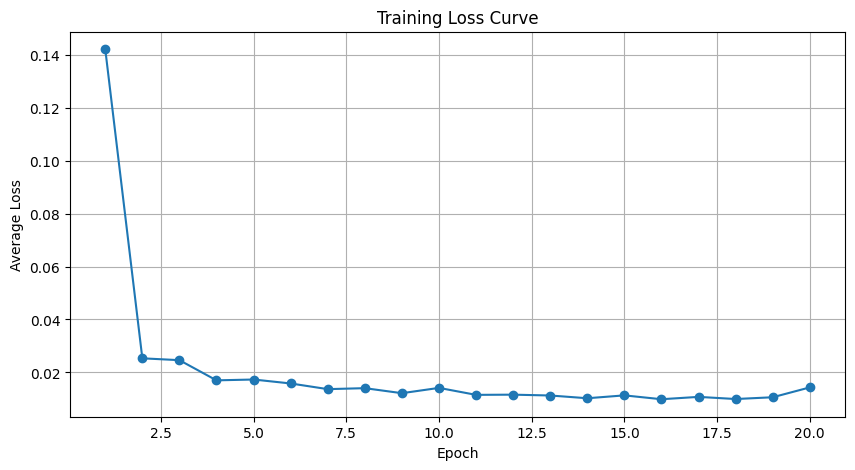

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

In [30]:

model.eval()
total_val_loss = 0.0

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        # forward
        out, _ = model(batch_x)
        loss = criterion(out, batch_y)
        total_val_loss += loss.item()

avg_val_loss = total_val_loss / len(val_loader)
print(f"Validation Loss: {avg_val_loss:.4f}")


Validation Loss: 0.0075


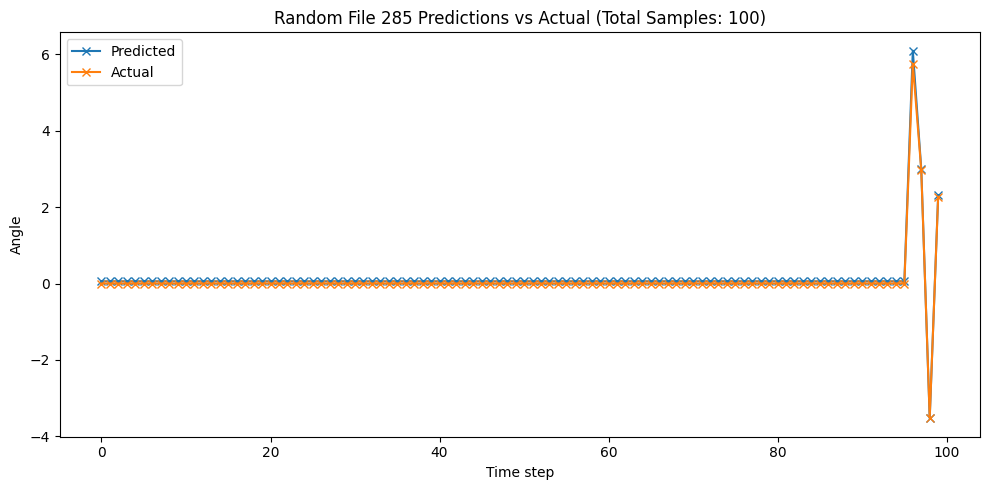

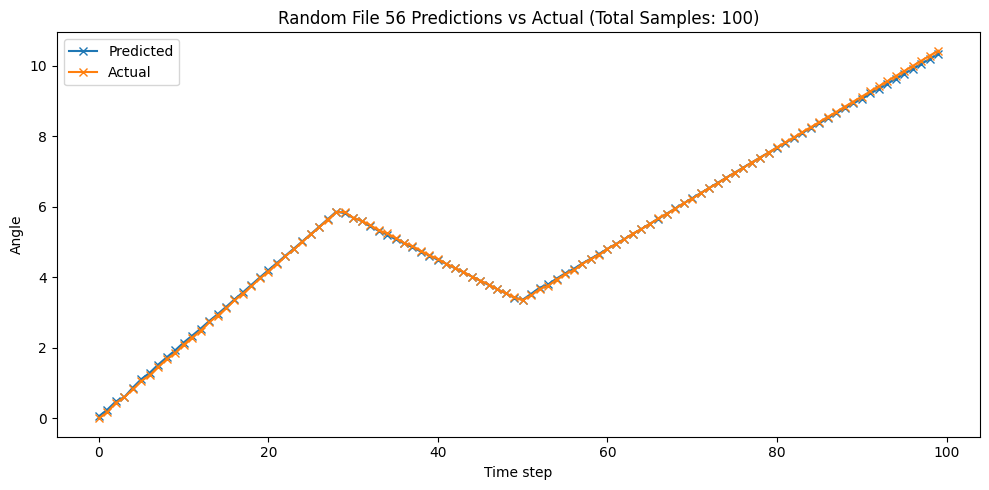

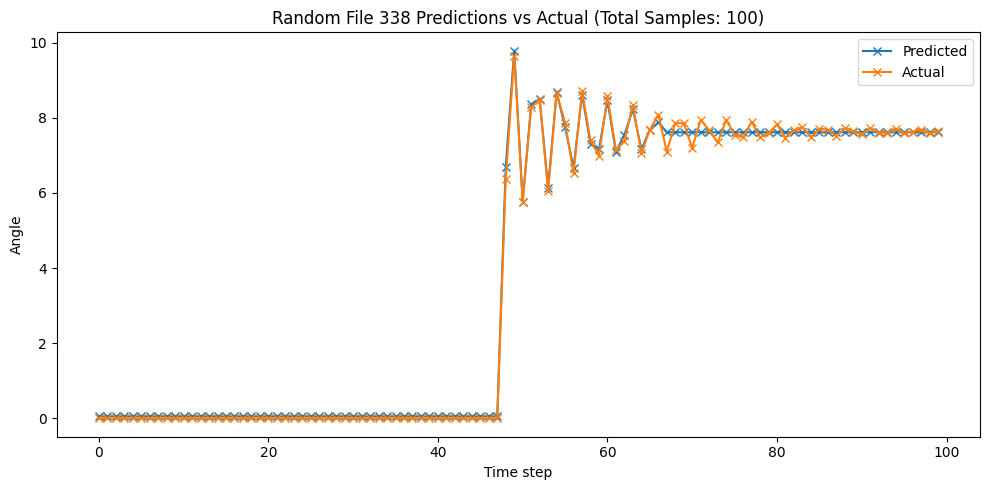

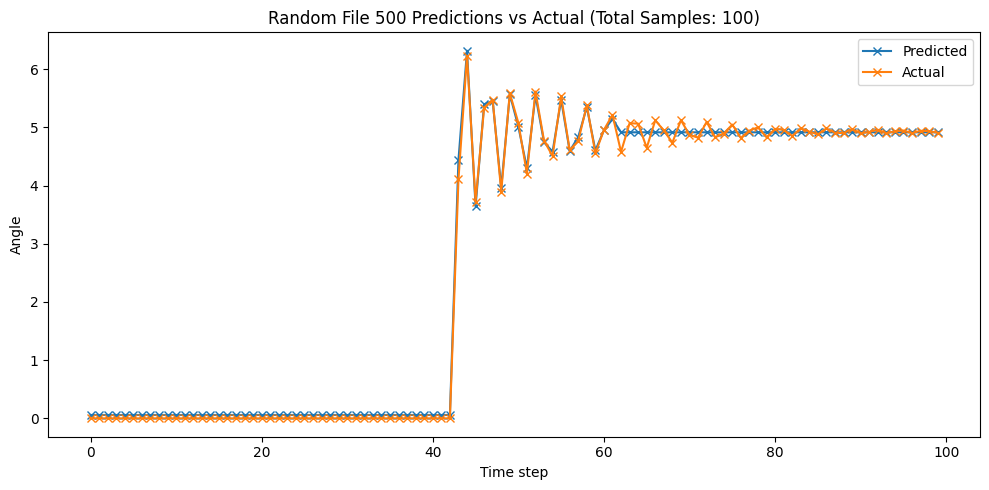

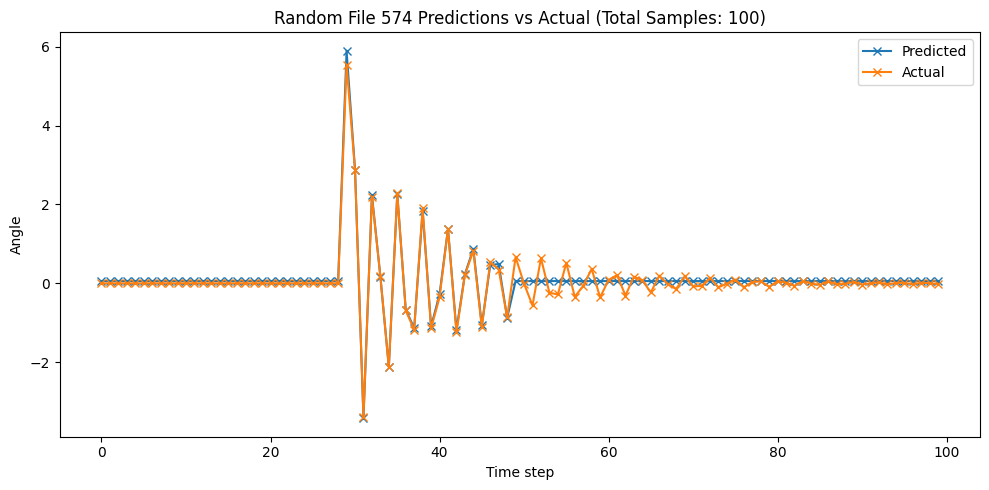

In [32]:
import os
import torch
import matplotlib.pyplot as plt
import random
from collections import deque

# load model
model_path = "checkpoints20-20/model_epoch_9.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()


num_files_to_plot = 5  # random chose 5
total_files = len(val_data)
if total_files < num_files_to_plot:
    selected_indices = list(range(total_files))
else:
    selected_indices = random.sample(range(total_files), num_files_to_plot)

for idx in selected_indices:
    seq = val_data[idx]  # choose seq
    
    # init q and pad with 0
    queue_length = 20
    input_queue = deque([0.0] * queue_length, maxlen=queue_length)
    
    preds = []  
    actuals = []
    
  
    for sample in seq:
        input_val, target_val = sample
        
    

        input_queue.append(input_val)
        
        # convert to tensor (1, 20, 1)
        input_tensor = torch.tensor(list(input_queue), dtype=torch.float32, device=device)
        input_tensor = input_tensor.unsqueeze(0).unsqueeze(-1)
        
        with torch.no_grad():
            pred, _ = model(input_tensor)
        pred_val = pred.squeeze().item()
        
        preds.append(pred_val)
        actuals.append(target_val)
       
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(preds)), preds, label="Predicted", marker='x')
    plt.plot(range(len(actuals)), actuals, label="Actual", marker='x')
    plt.title(f"Random File {idx} Predictions vs Actual (Total Samples: {len(preds)})")
    plt.xlabel("Time step")
    plt.ylabel("Angle")
    plt.legend()
    plt.tight_layout()
    plt.show()
